In [57]:
import pandas as pd             
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


from aux_fun import evaluate

import json

In [58]:
df = pd.read_csv('./data/train_imputed.csv')

In [59]:
y = df['NumberOfSales']
len(y)

523021

In [60]:
X = df.drop(df[['NumberOfSales', 'WindDirDegrees']], axis=1)

# Train-Test Split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9999)

In [62]:
dates_test = X_test['Date']

In [63]:
X_train = X_train.drop(['Date'], axis=1)
X_train.size()
X_test = X_test.drop(['Date'], axis=1)


TypeError: 'numpy.int64' object is not callable

In [ ]:
len(X_train)


In [ ]:
len(y_train)

# Model 

In [ ]:
#parameters
params_dict = {'n_estimators' : 15}

In [ ]:
rf = RandomForestRegressor(**params_dict)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [64]:
y_train.shape


(418416,)

In [65]:
X_train.shape

(418416, 42)

In [66]:
X_test.shape


(104605, 43)

In [67]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# we define which is out target 

def r2_cv(model, X_train, y, random_state=999999):
    # without this cv -- 
    r2= cross_val_score(model, X_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state))
    return(r2)

def rmse_cv(model, X_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

In [68]:
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)
yp = model_simple.predict(X_train)

# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(y_train,yp)
r2_xval_simple =  r2_cv(model_simple, X_train, y_train)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(y_train,yp,multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, X_train, y_train)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))

Linear Regression
	                  Train R2=0.909
	10-fold Crossvalidation R2=0.909
	                  Train RMSE=678758.973
	10-fold Crossvalidation RMSE=823.943


In [69]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y_train).mean() for alpha in alphas]
cv_r2_ridge = [r2_cv(Ridge(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

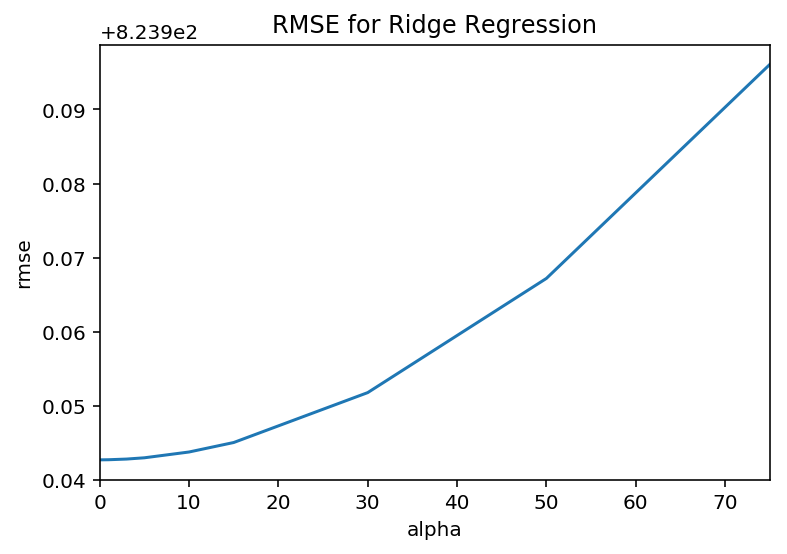

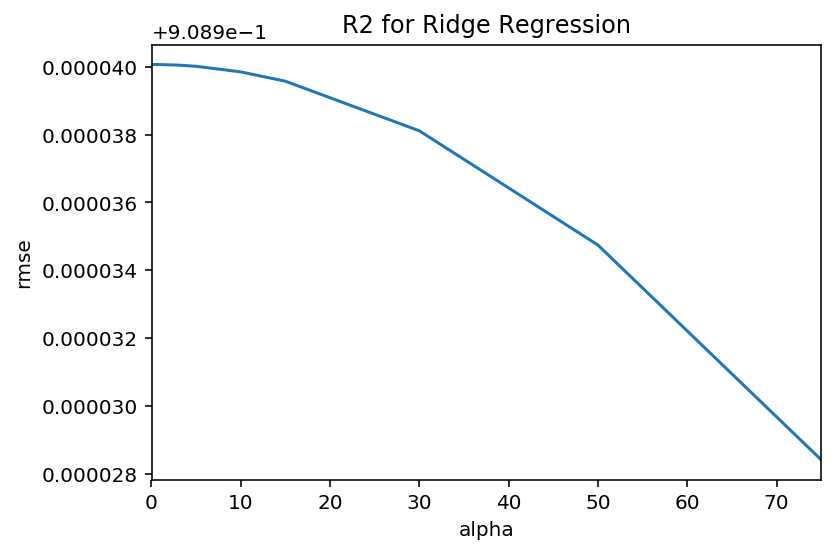

In [70]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_r2_ridge = pd.Series(cv_r2_ridge, index = alphas)

cv_ridge.plot(title = "RMSE for Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

cv_r2_ridge.plot(title = "R2 for Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()



### Creation of the submission 

In [ ]:
result = pd.DataFrame(X_test['StoreID'])
result['Month'] = pd.DatetimeIndex(dates_test).month
result['NumberOfSales'] = y_pred
#Group by Month
result =result.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].sum()

In [ ]:
X_test['NumberOfSales']= y_test
X_test['Date'] = dates_test

In [ ]:
evaluation =evaluate(X_test,result)
evaluation

In [ ]:
r2 = r2_score(y_test, y_pred)
r2

In [18]:
#r2 on grouped data
test =X_test.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].sum()
r2grouped = r2_score(test['NumberOfSales'], result['NumberOfSales'])
r2grouped

0.99603349723353596

In [19]:
model_result={'method': 'Random Forest',
       'parameters':params_dict,
       'evaluation': evaluation, 
       'r2':r2,
       'r2_grouped':r2grouped,
       'notes': 'None'
    }

In [ ]:
with open('results.json', 'a') as fp:
    json.dump(model_result, fp, indent=2)
    fp.write('\n')